In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import regularizers
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from keras.models import Sequential
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from numpy import NaN
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import psycopg2
import urllib
import keras
import os

<font size="30">Connect to the database</font>


In [18]:
#connect to the database
cur = conn.cursor()

<font size="30">data processing(2010/01/01-2022/12/31)</font>


In [19]:
#data cleaning process
def data_processing(dataset) -> pd.DataFrame:
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
    start_date = pd.to_datetime('2010-01-01')
    end_date = pd.to_datetime('2022-12-31')
    dataset_2020_2022 = dataset.query('date >= @start_date and date <= @end_date')
    dataset_2020_2022 = dataset_2020_2022[['date','grid','value']]
    dataset_2020_2022['value'].fillna(int(0),inplace=True)
    dataset_2020_2022['value'] = dataset_2020_2022['value'].astype('float')
    dataset_2020_2022 = dataset_2020_2022.groupby('grid').apply(lambda x: x.sort_values('date', ascending=True)).reset_index(drop=True)
    return dataset_2020_2022

#get the DSCI,SRSI, SPI, SSI data from the database 
def get_data_from_database(database_table:str)->pd.DataFrame:
    query = f'select * from "{database_table}"'
    df = pd.read_sql(query,con=engine)
    return df

df_DSCI = get_data_from_database('New_fcu_DSCI_City_mode_a_day')

#get the DSCI 
database_table = 'New_fcu_DSCI_City_mode_a_day'
query = f'select * from "{database_table}"'
df_DSCI = pd.read_sql(query,con=engine)

#get the SRSI
database_table = 'New_wra_City_srsi_day'
query = f'select * from "{database_table}"'
City_srsi = pd.read_sql(query,con=engine)

#get the SPI
database_table = 'New_qpesum_City_spi_day'
query = f'select * from "{database_table}"'
City_spi = pd.read_sql(query,con=engine)

#get the SSI
database_table = 'New_wra_City_ssi_day'
query = f'select * from "{database_table}"'
df_SSI = pd.read_sql(query,con=engine)

#conduct cleaning process
df_DSCI_2020_2022 = data_processing(df_DSCI)
df_SSI_2020_2022 = data_processing(df_SSI)
City_spi_2020_2022 = data_processing(City_spi)
City_srsi_2020_2022 = data_processing(City_srsi)

<font size="30">Merge each city code with its DSCI/SSI/SPI/SRSI values</font>

In [20]:
# Merge DataFrames outside the loop
merged_df_base = df_DSCI_2020_2022.merge(df_SSI_2020_2022, on=['date', 'grid'], how='left', suffixes=('_DSCI', '_SSI'))
merged_df_base = merged_df_base.merge(City_spi_2020_2022, on=['date', 'grid'], how='left', suffixes=('_SSI', '_SPI'))
merged_df_base = merged_df_base.merge(City_srsi_2020_2022, on=['date', 'grid'], how='left', suffixes=('_SPI', '_SRSI'))

output_dict = {}  # Initialize the output dictionary

# Iterate over grids
for i in tqdm(df_DSCI_2020_2022['grid']):
    merged_df = merged_df_base[merged_df_base['grid'] == i].copy()  # Filter merged_df_base for current grid

    # Drop columns with all NaN values
    if np.isnan(merged_df['value_SSI']).all():
        merged_df.drop(columns='value_SSI', inplace=True)
    if np.isnan(merged_df['value_SRSI']).all():
        merged_df.drop(columns='value_SRSI', inplace=True)
    else:
        merged_df[['value_SSI','value_SRSI']] = merged_df[['value_SSI','value_SRSI']].astype('float')

    output_dict[i] = merged_df

# Process the individual merged DataFrames
for i, merged_df in output_dict.items():
    # Perform any further operations or analysis on each merged_df
    print(f"Output for grid {i}:")
    print(merged_df)
    print("-------------------")


100%|██████████| 90212/90212 [01:32<00:00, 979.81it/s] 

Output for grid 10002:
           date   grid  value_DSCI  value_SPI
0    2010-01-01  10002         1.0      -0.67
1    2010-01-02  10002         1.0      -0.74
2    2010-01-03  10002         1.0      -0.49
3    2010-01-04  10002         1.0      -0.49
4    2010-01-05  10002         1.0      -0.43
...         ...    ...         ...        ...
4743 2022-12-27  10002         0.0       0.29
4744 2022-12-28  10002         0.0       0.40
4745 2022-12-29  10002         0.0       0.51
4746 2022-12-30  10002         0.0       0.50
4747 2022-12-31  10002         0.0       0.52

[4748 rows x 4 columns]
-------------------
Output for grid 10004:
           date   grid  value_DSCI  value_SSI  value_SPI  value_SRSI
4748 2010-01-01  10004         1.5      -1.49      -0.10       -0.25
4749 2010-01-02  10004         1.5      -1.45       0.19       -0.46
4750 2010-01-03  10004         1.5      -1.40       0.39       -0.47
4751 2010-01-04  10004         1.0      -1.24       0.39       -0.49
4752 2010-01

<font size="30">Train the data</font>

In [6]:
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data.iloc[:,0][i:i+window_size])
        y.append(data.iloc[:,0][i+window_size])
    return np.array(X), np.array(y)

In [ ]:
for i, merged_df in output_dict.items():
    df_train = output_dict[i].copy()
    df_train = df_train[['date','level_DSCI']]
    train_dates = pd.to_datetime(df_train['date'])
    df_train.set_index('date', inplace=True)
    df_train = pd.DataFrame(df_train)
    train_size = int(len(df_train) * 0.8)
    train_df = df_train.iloc[:train_size]
    val_df = df_train.iloc[train_size:]
    window_size = 30
    X_train, y_train = create_sequences(train_df, window_size)
    X_val, y_val = create_sequences(val_df, window_size)
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    y_val = np.reshape(y_val, (y_val.shape[0], 1))
    print("X_train.shape：",X_train.shape,'y_train.shape：',y_train.shape,"X_val.shape：",X_val.shape,'y_val.shape：',y_val.shape)
    # Define the LSTM model2 architecture
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', input_shape=(window_size, 1), return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        tf.keras.layers.Dense(1)])
    # Compile the model2
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model2
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),verbose=1)
    test_loss = model.evaluate(X_val, y_val)
    print('Test Loss: {:.2f}'.format(test_loss))
    y_pred = model.predict(X_val)

    print('-------------------testing evaluation------------------------')
    rounded_y_pred = np.round(y_pred)
    mse = mean_squared_error(y_val, rounded_y_pred)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    r2 = r2_score(y_val, rounded_y_pred)
    print('R-squared:', r2)
    # Plot the data
    
    y_val_viz = np.squeeze(y_val)
    y_pred_viz = np.squeeze(y_pred)
    compare = pd.DataFrame({'true': y_val_viz, 'predict': y_pred_viz})
    compare['date'] = val_df[-920:].reset_index()['date']
    compare['predict'] = compare['predict'].apply(lambda x:round(x))
    df = compare.copy()
    plt.figure(figsize=(20, 10))
    # Plot the 'true' and 'predict' values against the 'date' column
    plt.plot(df['date'], df['true'], label='True',)
    plt.plot(df['date'], df['predict'], label='Predict')
    # Set the x-axis label, y-axis label, and title of the plot
    plt.xlabel('Date', color='blue',size=20)
    plt.ylabel('Value', color='green',size=20)
    plt.title('True vs Predicted Values')
    plt.xticks(color='#f00',
            fontsize=15) 
    plt.yticks(ticks=[0,1,2,3,4],color='#f00',
            fontsize=30) 
    plt.legend(fontsize="20")
    # Display the plot
    plt.show()
    if rmse < 0.3 and r2>0.7:
        directory =f'{os.getcwd()}\\model_save\\prediction_result_30\\DSCI'
        model.save(f'{directory}//{i}_DSCI_30_rmse_{round(rmse,2)}_r2_{round(r2,2)}.h5')
    else:
        model.save(f'{directory}//{i}_DSCI_30_rmse_{round(rmse,2)}_r2_{round(r2,2)}_F.h5')

<font size="30">USE DSCI VALUE</font>

In [21]:


def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)


X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0047
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.06512343028753005
R-squared: 0.8585017323939147


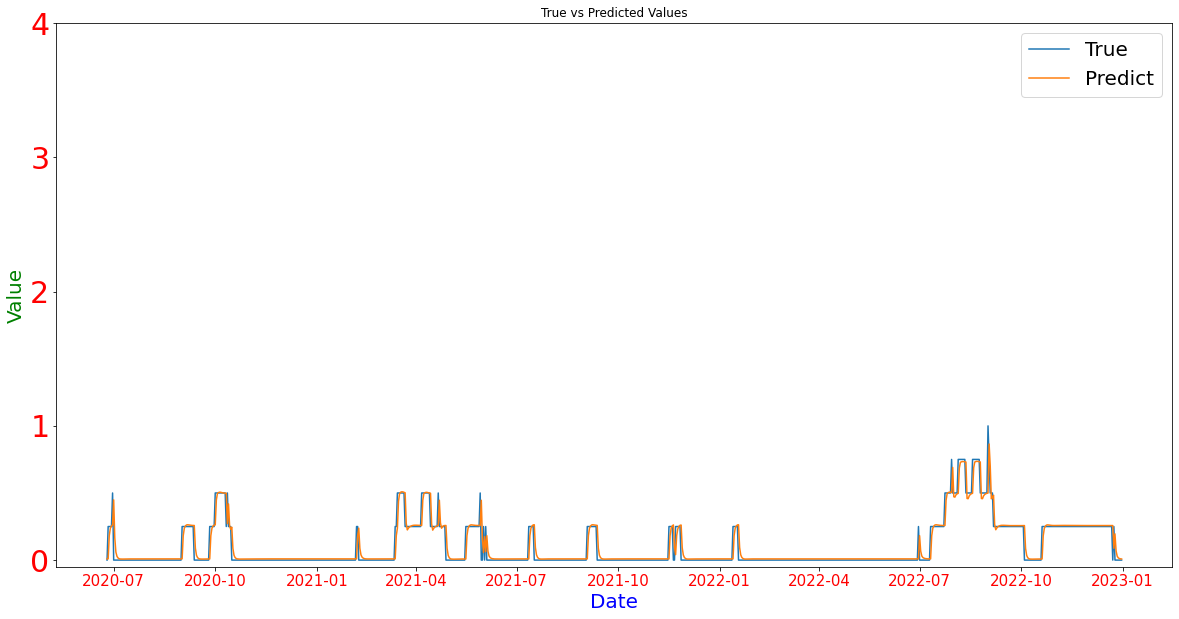

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0031
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.05085217126964349
R-squared: 0.9609541306934325


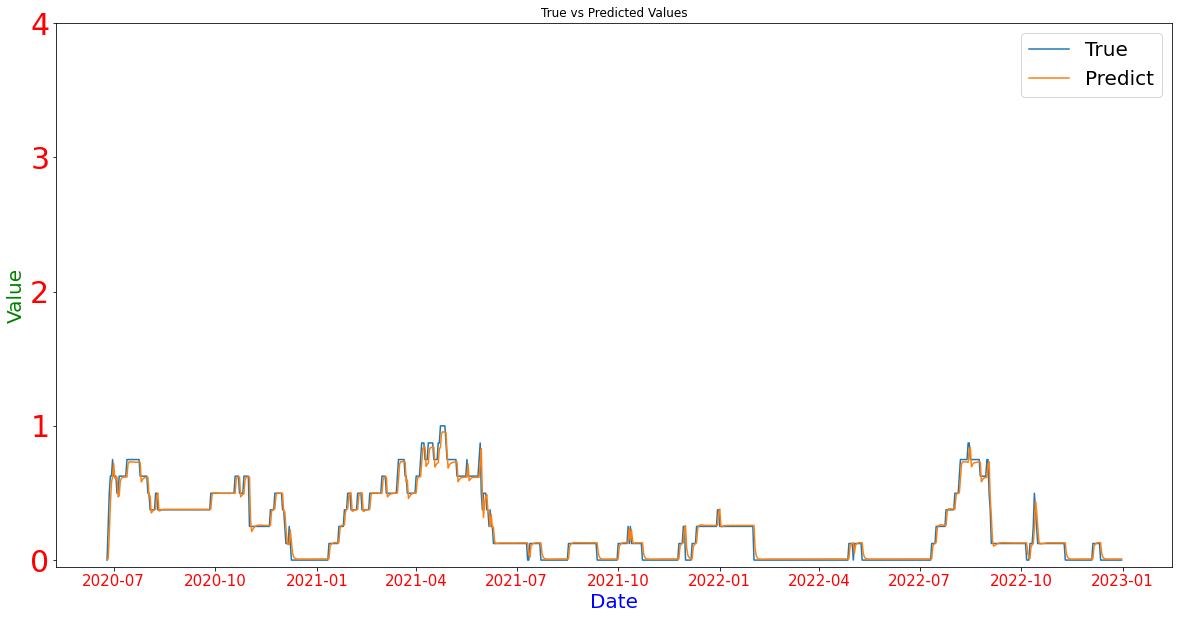

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0031
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.05124093710938405
R-squared: 0.9590428060537483


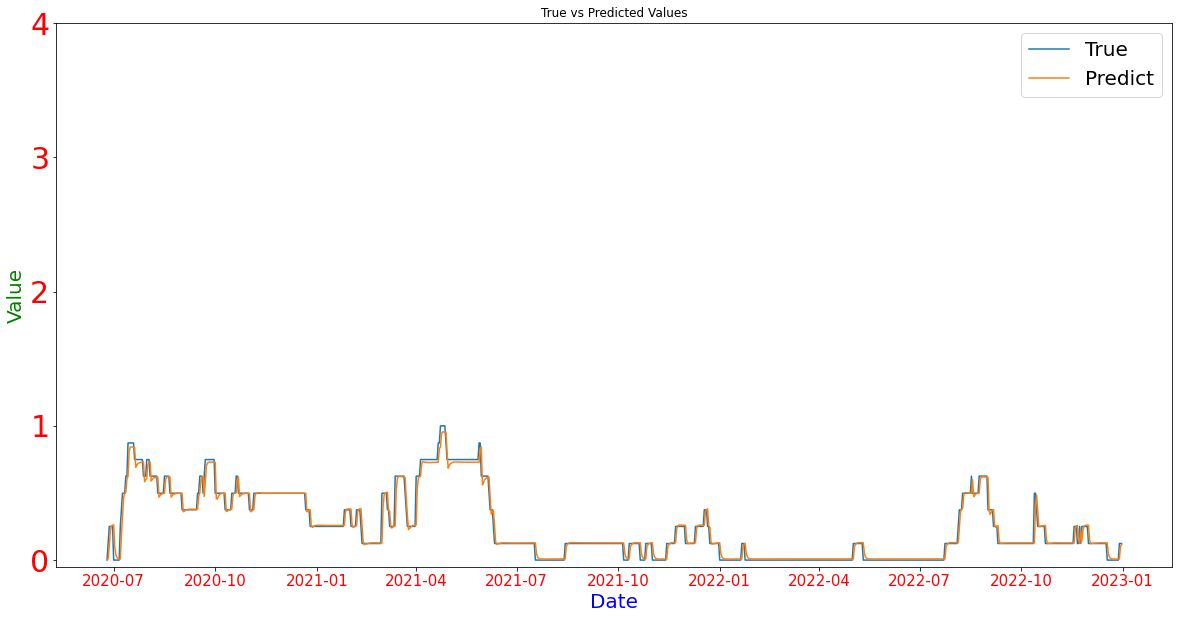

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0032
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.05170492527998514
R-squared: 0.9585761993252446


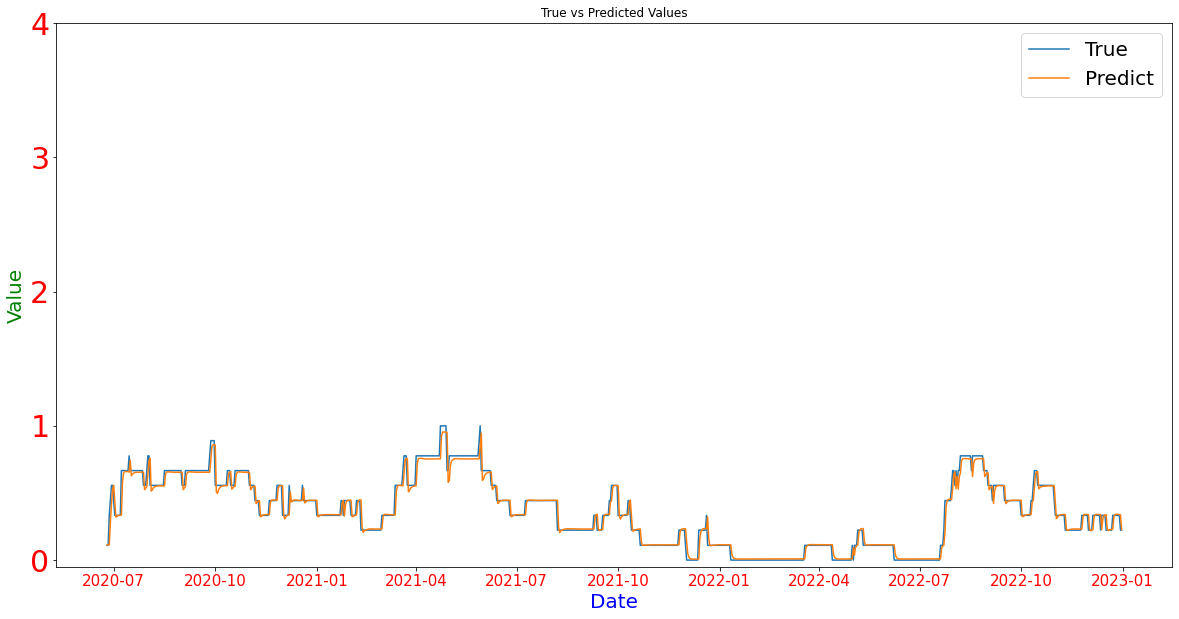

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0044
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.06292056071335857
R-squared: 0.8825895225174077


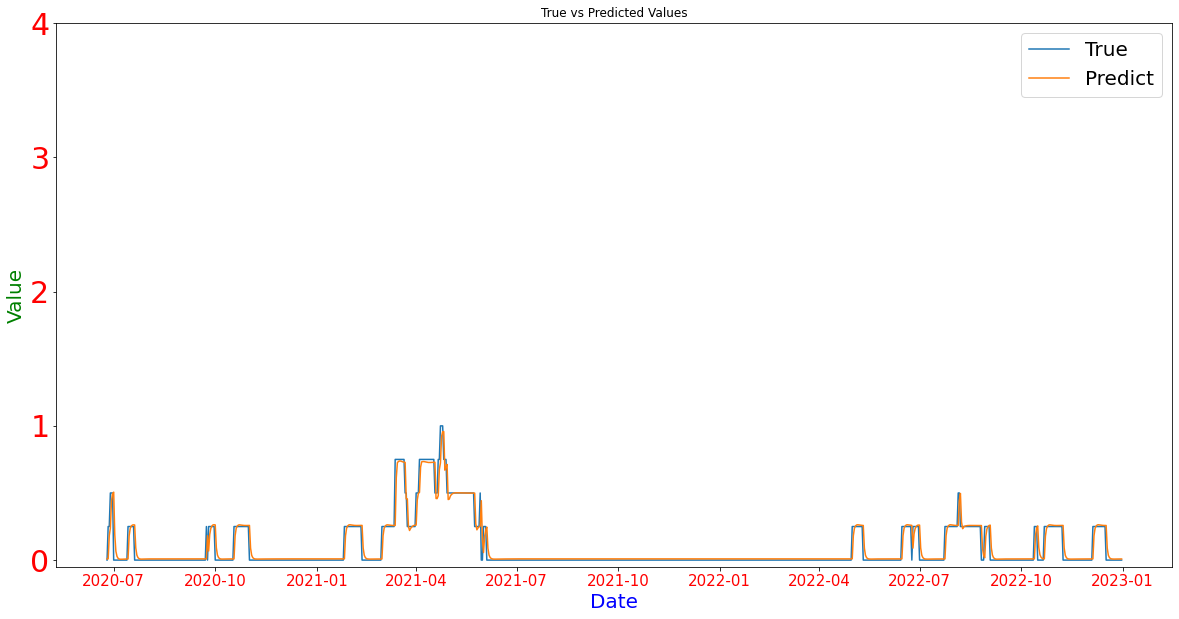

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0038
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.05741860816861805
R-squared: 0.9473777646667186


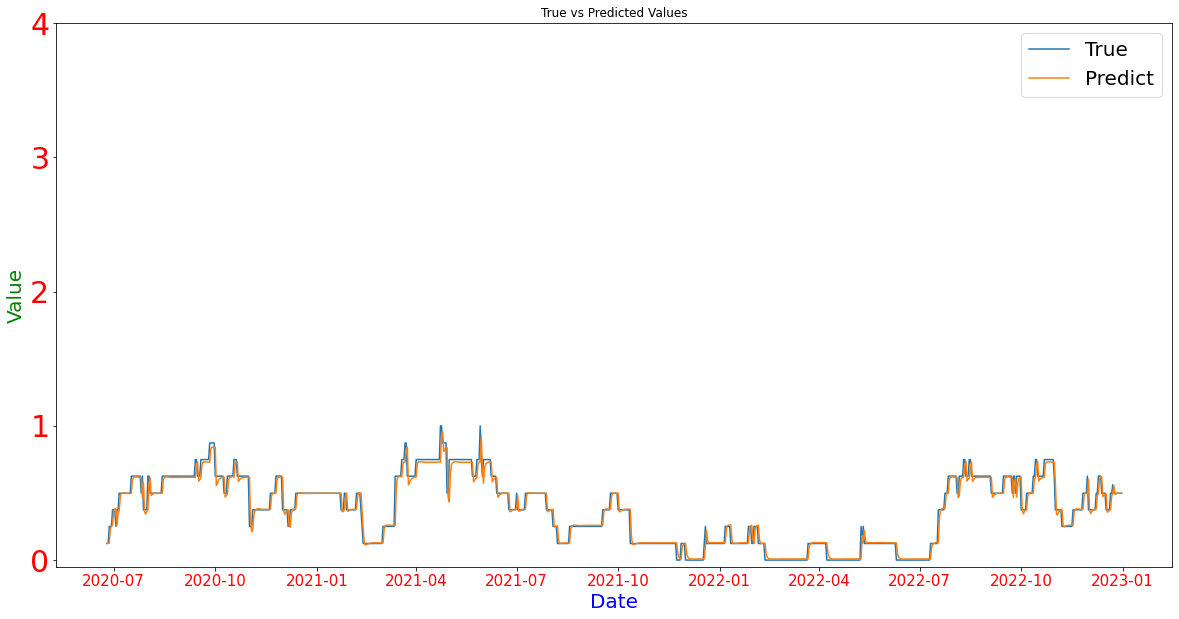

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0038
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.05735503581028251
R-squared: 0.9488232518916448


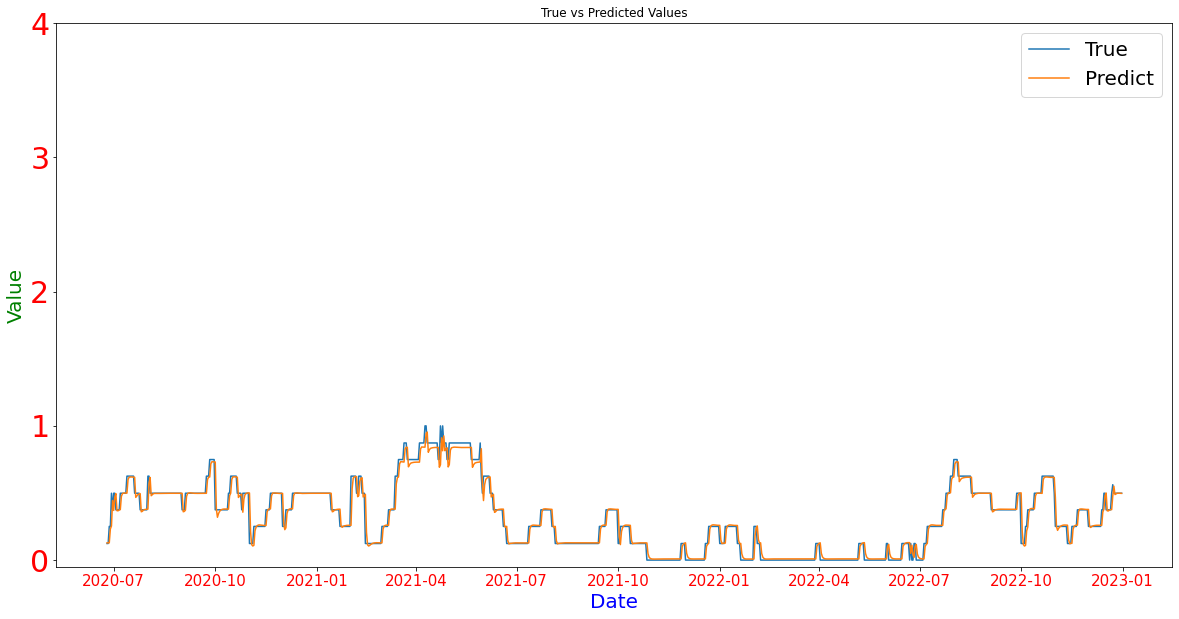

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0044
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.06221603084257513
R-squared: 0.9264279346867124


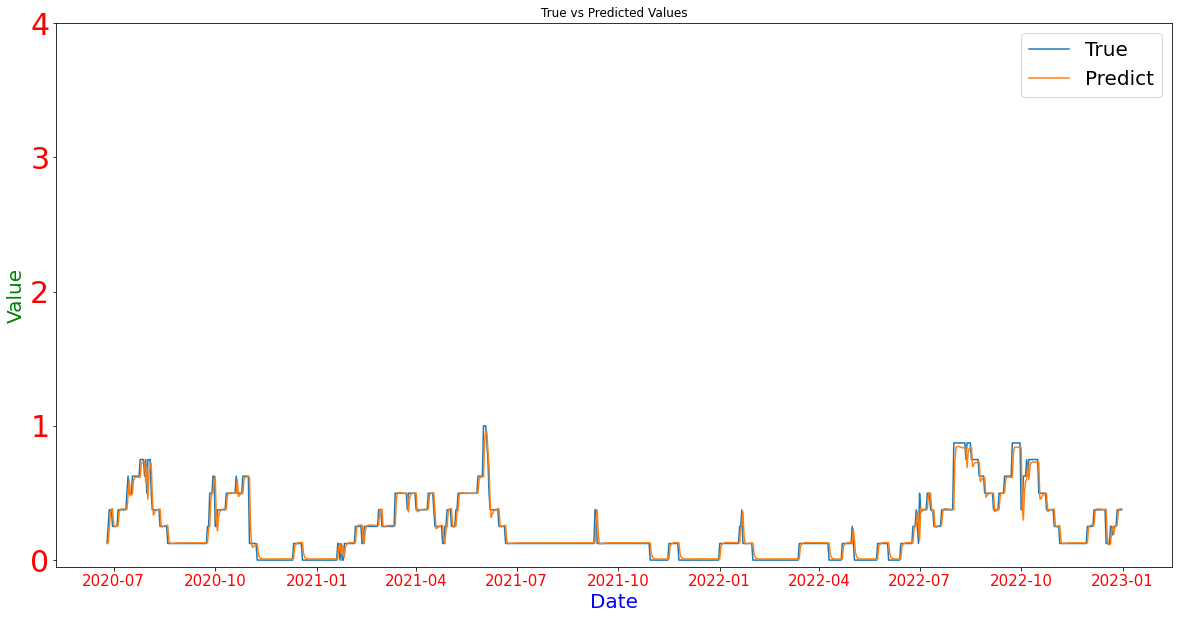

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0084
Test Loss: 0.01
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.08895741127120235
R-squared: 0.8471492571567664


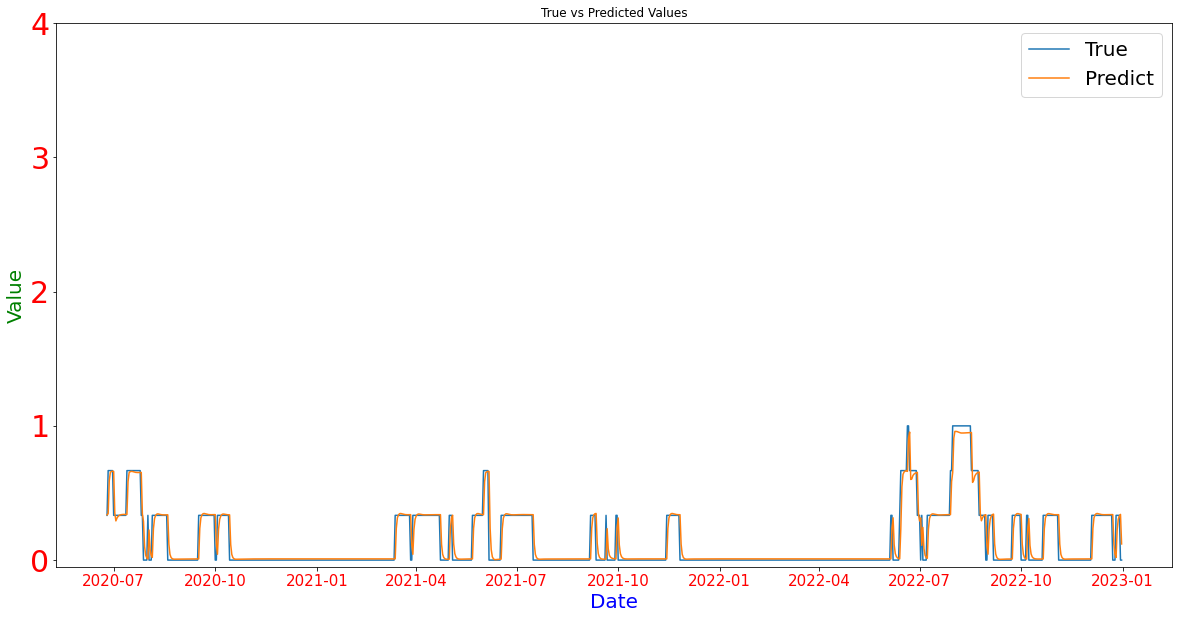

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0073
Test Loss: 0.01
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.08229599064573093
R-squared: 0.7889887855796767


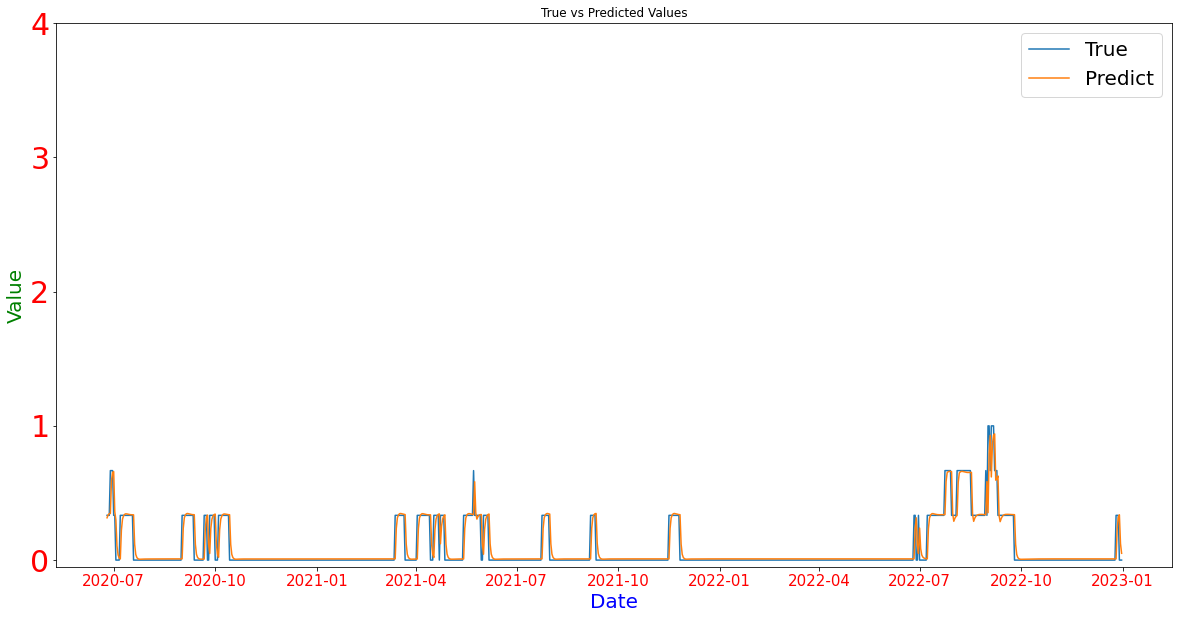

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0033
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.05272014320777096
R-squared: 0.9170260736852687


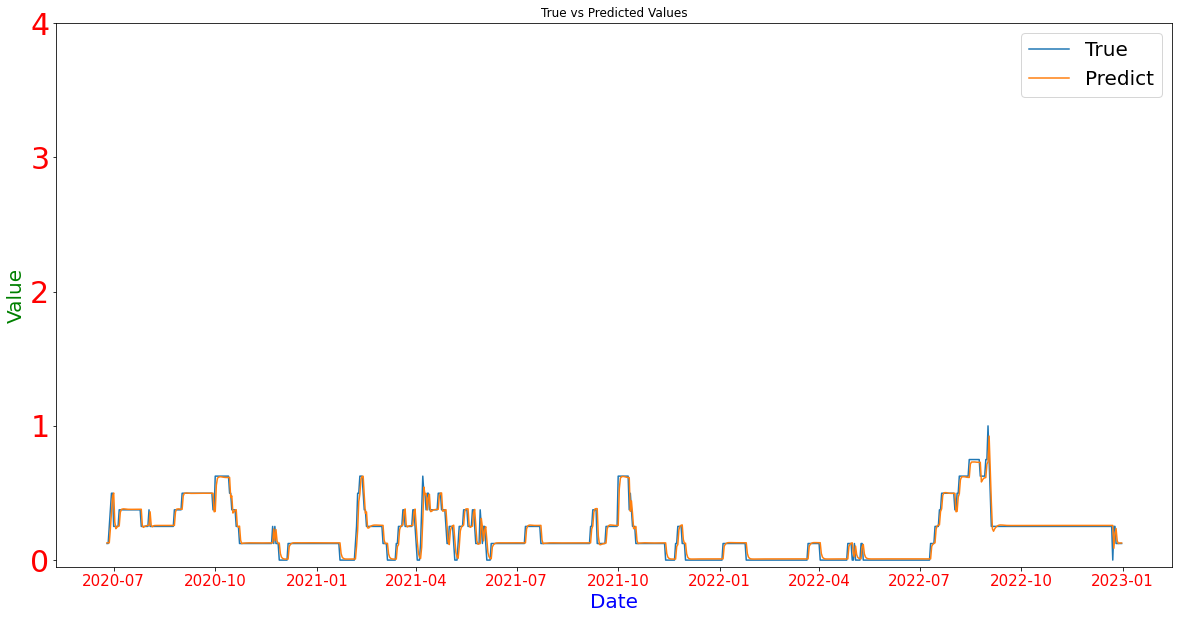

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 5ms/step - loss: 0.0027
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.046688573271743694
R-squared: 0.9631907525342419


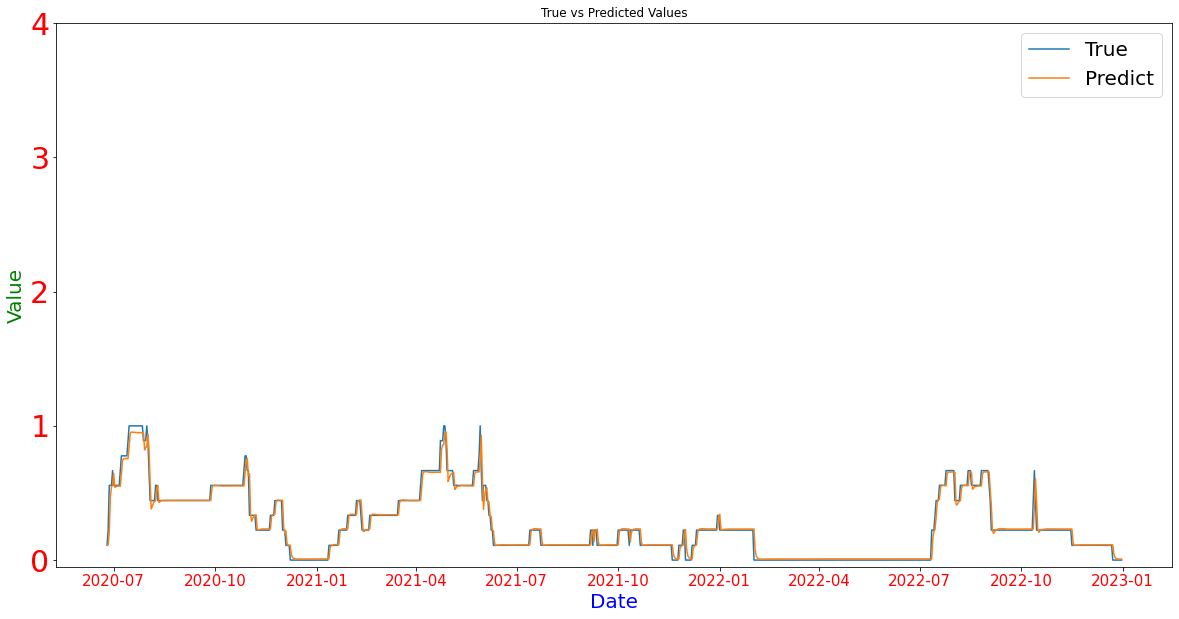

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0047
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.06487096799241647
R-squared: 0.9411551732415511


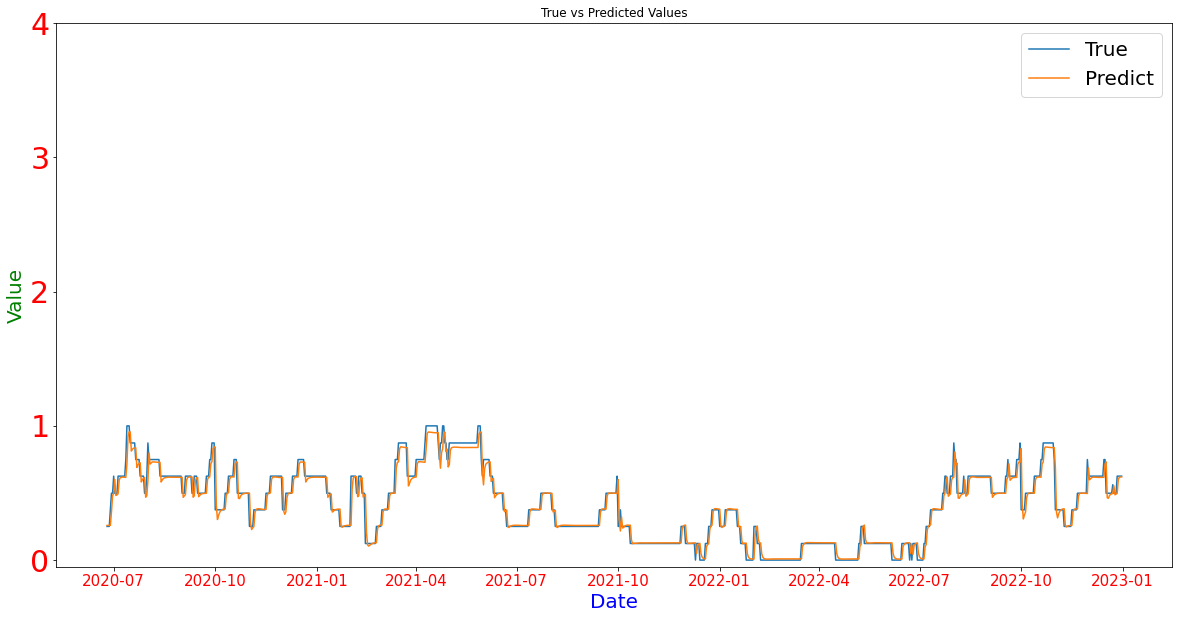

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0034
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.053987376763849466
R-squared: 0.9373485060522644


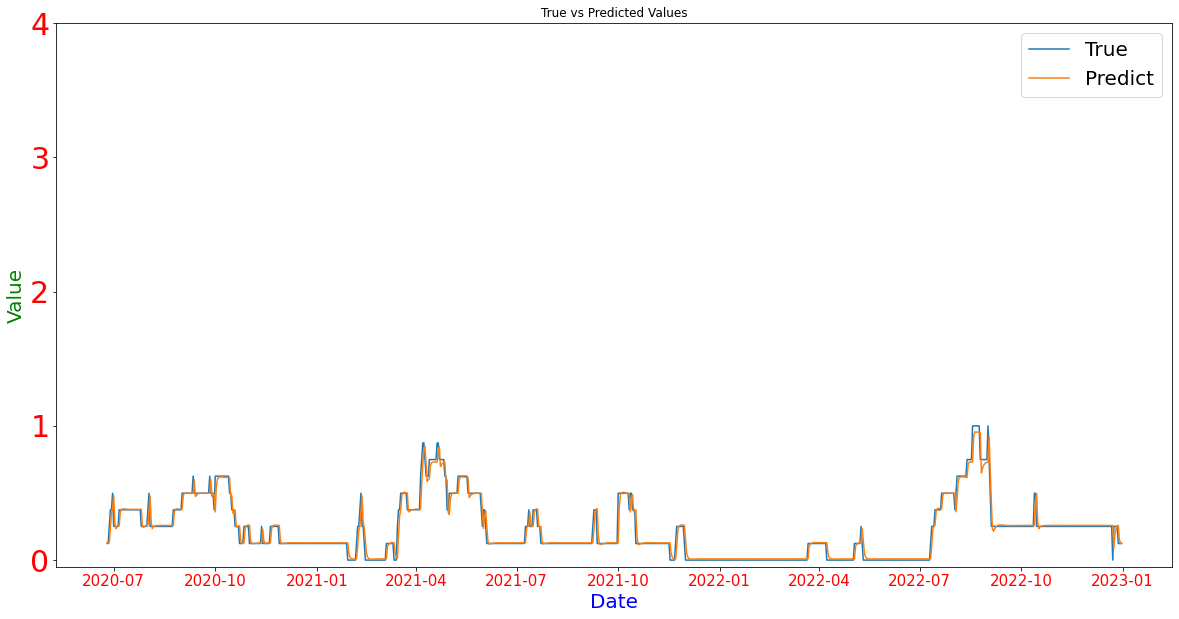

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0076
Test Loss: 0.01
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.08417505551312737
R-squared: 0.8436590793636338


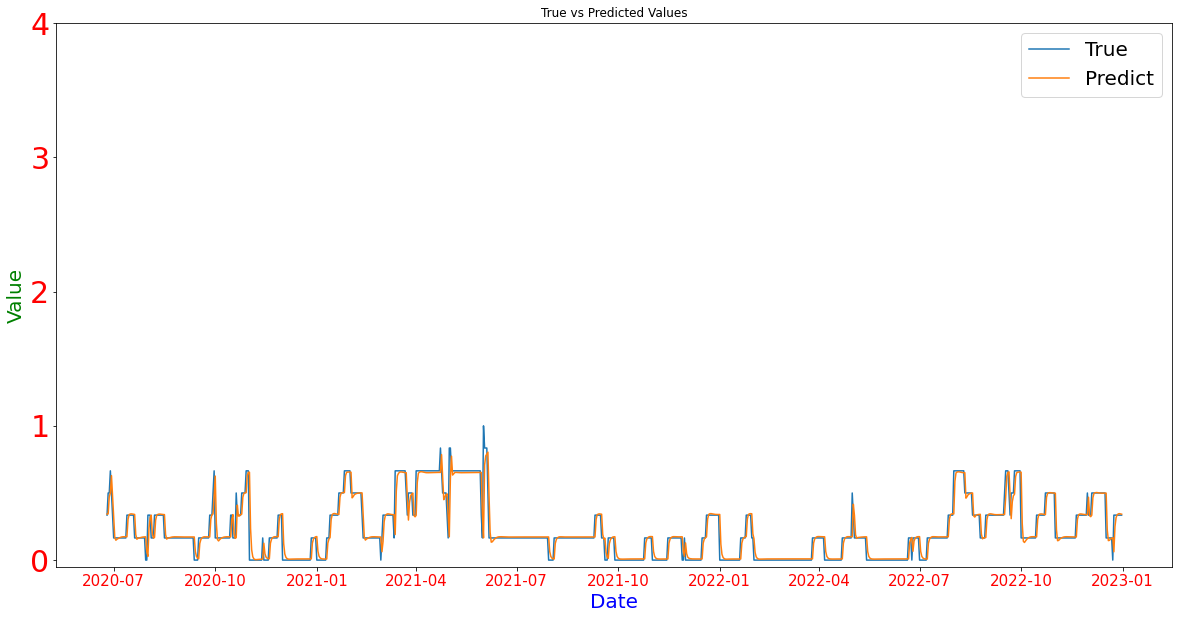

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0037
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.05678274745745992
R-squared: 0.9429610174613143


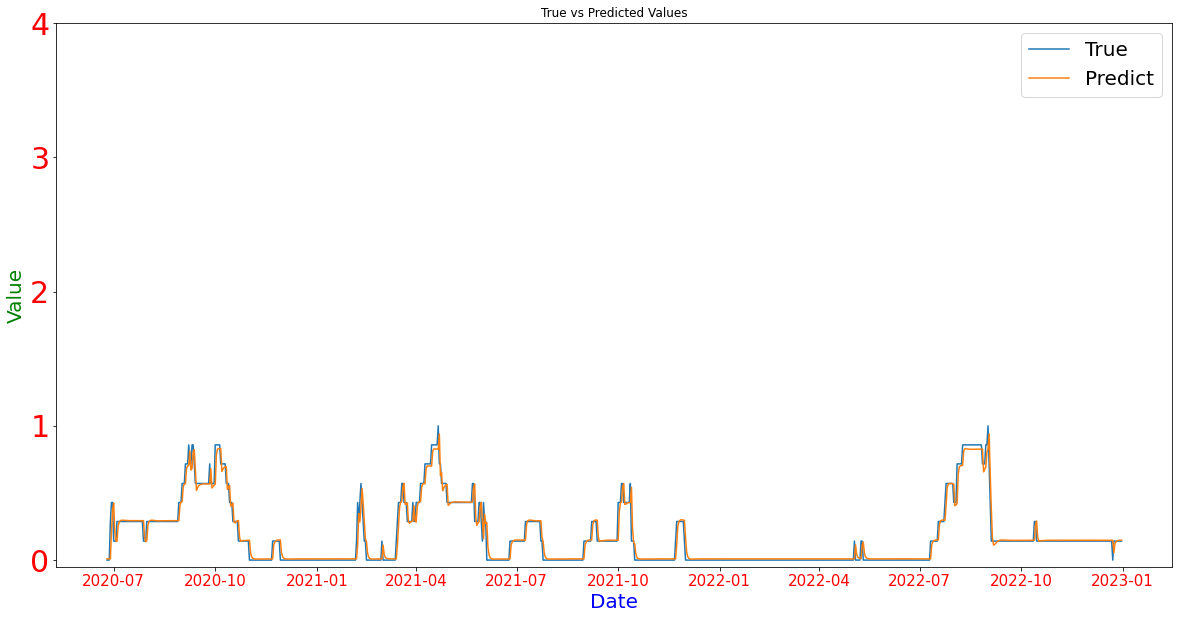

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0025
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.044966605109694635
R-squared: 0.9650408065433782


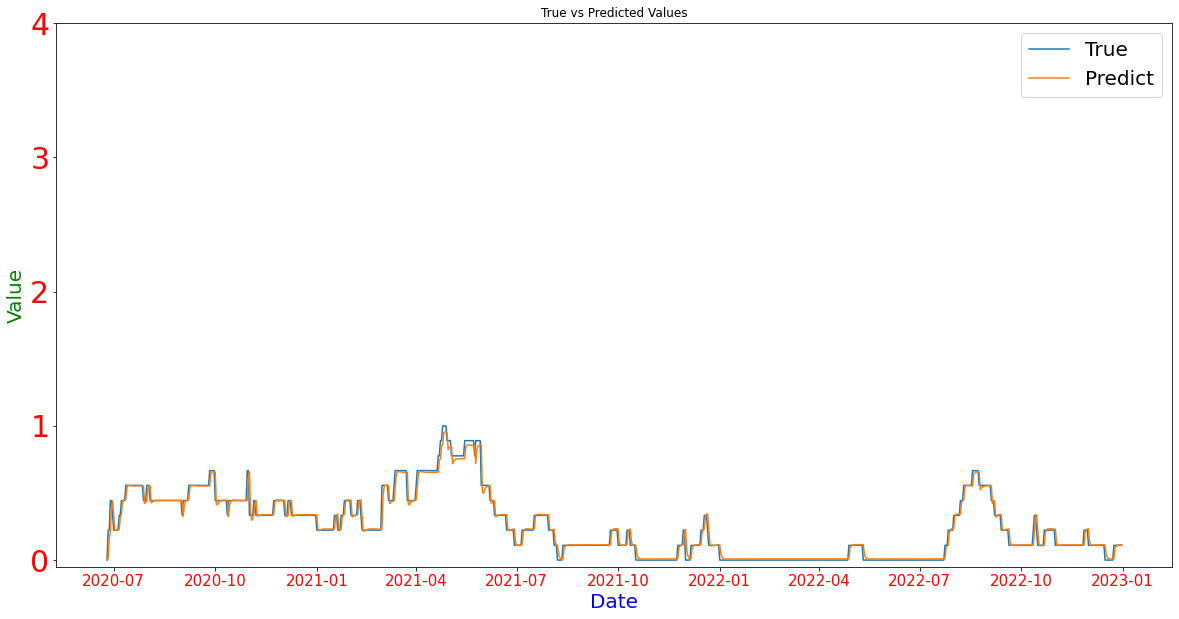

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0050
Test Loss: 0.01
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.06746865014816994
R-squared: 0.9297468615182687


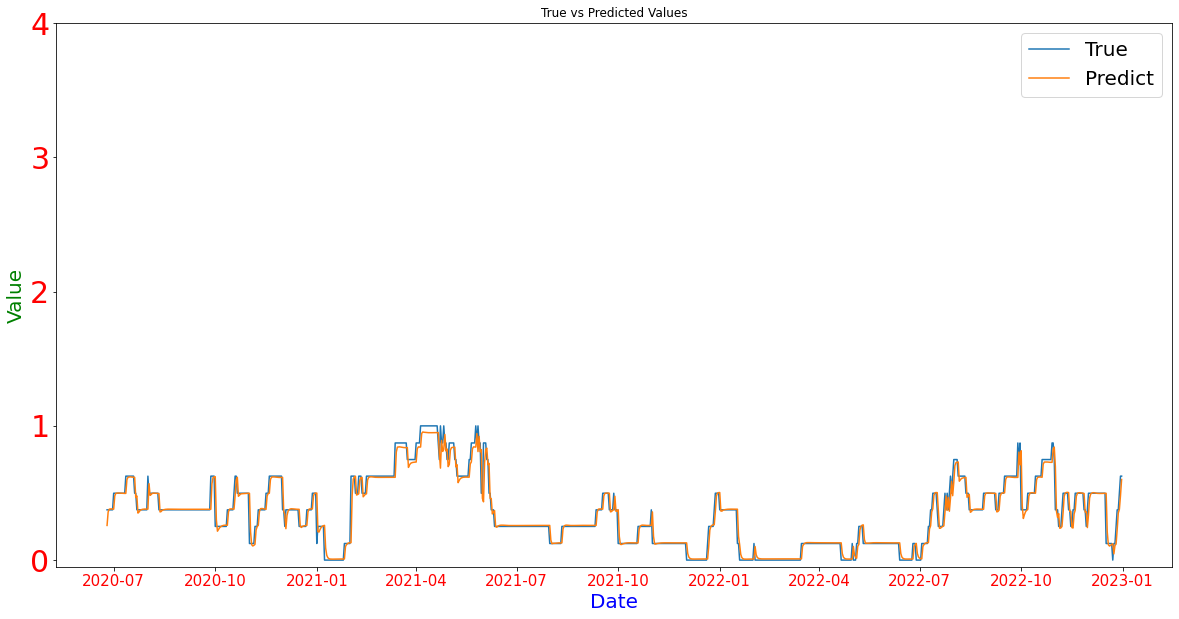

X_train.shape： (3768, 30, 1) y_train.shape： (3768, 1) X_val.shape： (920, 30, 1) y_val.shape： (920, 1)
29/29 [==============================] - 0s 4ms/step - loss: 0.0030
Test Loss: 0.00
29/29 [==============================] - 0s 4ms/step
-------------------testing evaluation------------------------
RMSE: 0.05054329011398513
R-squared: 0.9611308069873368


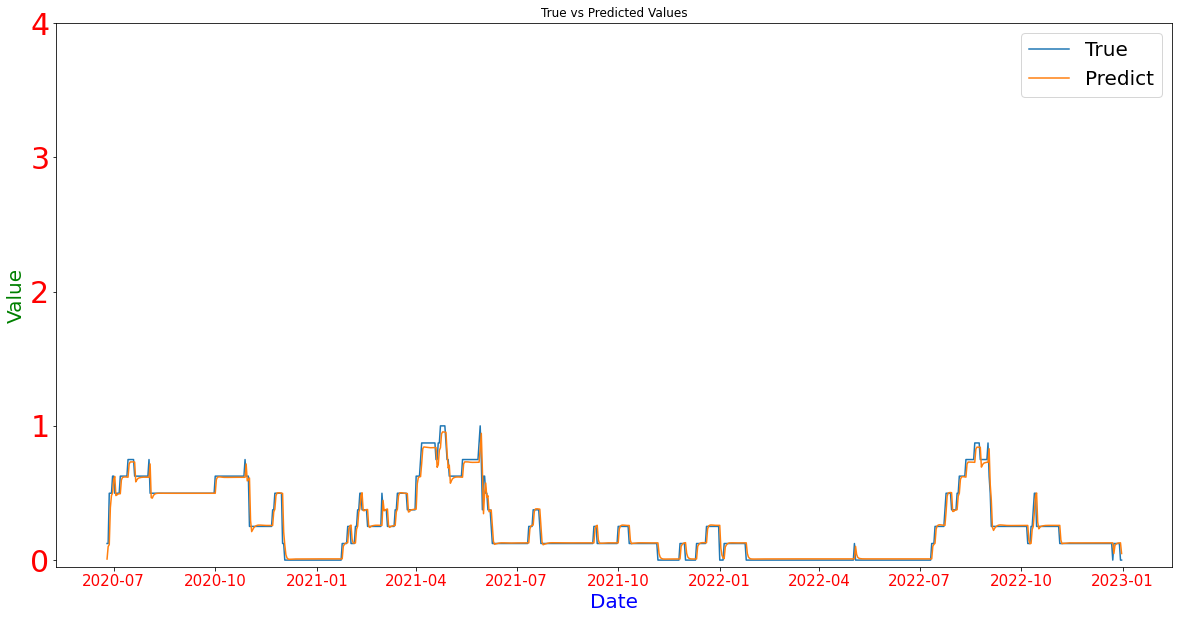

In [24]:
for i, merged_df in output_dict.items():
    df_train = output_dict[i].copy()
    df_train = df_train[['date','value_DSCI']]
    train_dates = pd.to_datetime(df_train['date'])
    df_train.set_index('date', inplace=True)
    df_train = pd.DataFrame(df_train)
    train_size = int(len(df_train) * 0.8)
    train_df = df_train.iloc[:train_size]
    val_df = df_train.iloc[train_size:]

    sc = MinMaxScaler()
    training_set_scaled = sc.fit_transform(train_df)
    testing_set_scaled = sc.fit_transform(val_df)

    window_size = 30
    X_train, y_train = create_sequences(training_set_scaled, window_size)
    X_val, y_val = create_sequences(testing_set_scaled, window_size)
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    y_val = np.reshape(y_val, (y_val.shape[0], 1))
    print("X_train.shape：",X_train.shape,'y_train.shape：',y_train.shape,"X_val.shape：",X_val.shape,'y_val.shape：',y_val.shape)


    keras.backend.clear_session()
    regressor = Sequential()
    regressor.add(LSTM(units = 100, input_shape=(window_size, 1)))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


    '''
    # Define the LSTM model2 architecture
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(window_size, 1), return_sequences=True,kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation='relu'),
    tf.keras.layers.Dense(1)])
    model.compile(optimizer='adam', loss='mean_squared_error')
    #history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])
    '''
    test_loss = model.evaluate(X_val, y_val)
    print('Test Loss: {:.2f}'.format(test_loss))
    y_pred = model.predict(X_val)


    y_predicted_descaled = sc.inverse_transform(y_pred)
    y_train_descaled = sc.inverse_transform(y_train)
    y_test_descaled = sc.inverse_transform(y_val)

    y_pred = y_pred.ravel()
    y_tested = y_val.ravel()



    print('-------------------testing evaluation------------------------')
    mse = mean_squared_error(y_tested, y_pred)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    r2 = r2_score(y_tested, y_pred)
    print('R-squared:', r2)
    # Plot the data

    y_val_viz = np.squeeze(y_tested)
    y_pred_viz = np.squeeze(y_pred)
    compare = pd.DataFrame({'true': y_val_viz, 'predict': y_pred_viz})
    compare['date'] = val_df[-920:].reset_index()['date']
    df = compare.copy()
    plt.figure(figsize=(20, 10))
    # Plot the 'true' and 'predict' values against the 'date' column
    plt.plot(df['date'], df['true'], label='True',)
    plt.plot(df['date'], df['predict'], label='Predict')
    # Set the x-axis label, y-axis label, and title of the plot
    plt.xlabel('Date', color='blue',size=20)
    plt.ylabel('Value', color='green',size=20)
    plt.title('True vs Predicted Values')
    plt.xticks(color='#f00',fontsize=15) 
    plt.yticks(ticks=[0,1,2,3,4],color='#f00',fontsize=30) 
    plt.legend(fontsize="20")
    plt.show()

    if rmse < 0.3 and r2>0.7:
        directory =f'{os.getcwd()}\\model_save\\prediction_result_30\\DSCI'
        model.save(f'{directory}//{i}_DSCI_30_rmse_{round(rmse,2)}_r2_{round(r2,2)}.h5')
    else:
        model.save(f'{directory}//{i}_DSCI_30_rmse_{round(rmse,2)}_r2_{round(r2,2)}_F.h5')